In [104]:
import os, glob, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import fmin_slsqp
from typing import List
from operator import add
from toolz import reduce, partial

In [105]:
# add your own file path here 
#aria_FILE_PATH = '/Users/ernyk/OneDrive - National University of Singapore/nus/bt4241/bt4241 proj ideas/BT4241-2510-Project/did-by-country/ARIA Year End Charts' 
billboard_FILE_PATH = '/Users/ernyk/OneDrive - National University of Singapore/nus/bt4241/bt4241 proj ideas/BT4241-2510-Project/did-by-country/Billboard Year End Charts'

# audio features to consider
columns_to_read = ['BPM', 'Dance', 'Energy', 'Happy']
columns_to_read_genre = columns_to_read.copy()
columns_to_read_genre.extend(["Parent Genres"])
#covariates = ["GDP_growth", "unemployment_change", "inflation"]
covariates = ["GDP_growth"]

# create panel dataframe
chart_panel_df = pd.DataFrame(columns=['Genre', 'Treat_Grp', 'Year', 'post_recession', 'BPM', 'Dance', 'Energy', 'Happy'])

### data merging

macroeconomic data processing

In [106]:
# set columns to read from macroeconomic data
def set_time_period(start, end):
    years = list(map(str, list(range(start, end))))
    li = ["Country Code"]
    li.extend(years)
    return years, li

years, li = set_time_period(1989, 2014)

# read macroeconomic data
def read_data(csv_name, col_list, first_col):
    stats_df = pd.read_csv(csv_name, usecols=col_list)

    # filter for australian and US data
    stats_df.loc[(stats_df['Country Code'] == 'AUS') | (stats_df['Country Code'] == 'USA')]

    #drop first column (used for calculation)
    stats_df.drop([first_col], axis=1)
    return stats_df

gdp_stats_df = read_data("gdp_growth.csv", li, "2003")
inflation_stats_df = read_data('inflation_rate.csv', li, "2003")
unemployment_stats_df = read_data('unemployment_rate.csv', li,"2003")

# calculate yearly change in unemployment rate
unemployment_change_stats_df = unemployment_stats_df.copy()
for i in years:
    if i == '1989':
        continue
    i_prev = str(int(i) - 1)
    unemployment_change_stats_df[i] = (unemployment_change_stats_df[i] - unemployment_change_stats_df[i_prev]) / unemployment_change_stats_df[i]
        

covariate_data = [gdp_stats_df, inflation_stats_df, unemployment_change_stats_df]
    

create genre data

joining macroeconomic statistics data with song data 

In [107]:
all_files = os.listdir(billboard_FILE_PATH)
curr_year_csv = pd.DataFrame()
for filename in all_files:
    year = filename.split()[0]
    curr_year_csv = pd.read_csv(os.path.join(billboard_FILE_PATH, filename), usecols=columns_to_read_genre)

    genre_split = curr_year_csv
    genre_split['Parent Genres'] = genre_split['Parent Genres'].str.split(',') #.explode().reset_index(drop=True)
    genre_split = genre_split.explode('Parent Genres')
    genre_split['Parent Genres'] = genre_split['Parent Genres'].str.strip()
    genre_split.fillna("NaN",inplace=True)

    genre_aggregated = genre_split.groupby("Parent Genres")[columns_to_read].mean()

    post_recession = 0 if int(year) < 2008 else 1
    genres_list = genre_split["Parent Genres"].unique()
    for genre in genres_list:
        post_recession = 0 if int(year) < 2008 else 1
        treatment = 1 if genre == "Pop" else 0
        new_row_df = pd.DataFrame({
            'Genre': [genre],
            'Treat_Grp': [treatment],
            'Year': [int(year)],
            'GDP_growth': gdp_stats_df.at[251, year], 
            #'inflation': inflation_stats_df.at[251, year],
            #'unemployment_change': unemployment_stats_df.at[251, year],
            'post_recession': [post_recession], 
            'BPM': [genre_aggregated.loc[genre, 'BPM']], 
            'Dance': [genre_aggregated.loc[genre,'Dance']], 
            'Energy': [genre_aggregated.loc[genre, 'Energy']],
            'Happy': [genre_aggregated.loc[genre,'Happy']]
        })
        chart_panel_df = pd.concat([chart_panel_df, new_row_df], ignore_index=True)
    

C:\Users\ernyk\AppData\Local\Temp\ipykernel_27724\2759674050.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chart_panel_df = pd.concat([chart_panel_df, new_row_df], ignore_index=True)


In [108]:
to_drop = chart_panel_df.groupby("Genre", as_index=False).count()#.filter(lambda x: x["Treat_Grp"] > 2)
#to_drop = genres_list_total.filter(lambda x: x["Year"] < 5)
to_drop = to_drop[to_drop.Treat_Grp < 10]["Genre"]
#to_drop = ['Pop', 'R&B', "Hip Hop"]
chart_panel_df = chart_panel_df[~chart_panel_df["Genre"].isin(to_drop)]
#chart_panel_df = chart_panel_df[chart_panel_df["Genre"].isin(to_drop)]

### checking for parallel trends assumption
plotted trends of audio features over time, visually inspected graph before recession to determine if audio features of songs followed similar trends

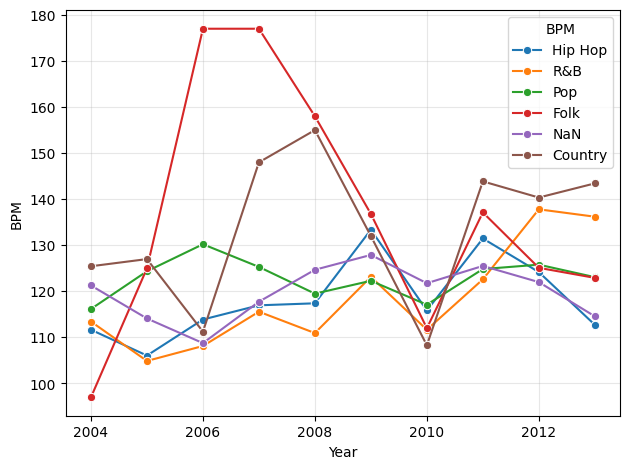

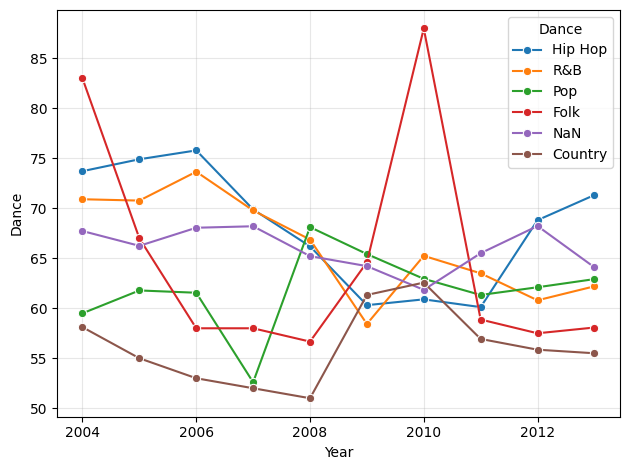

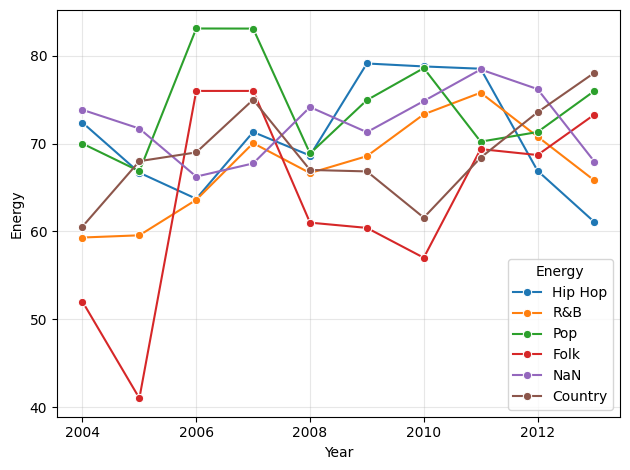

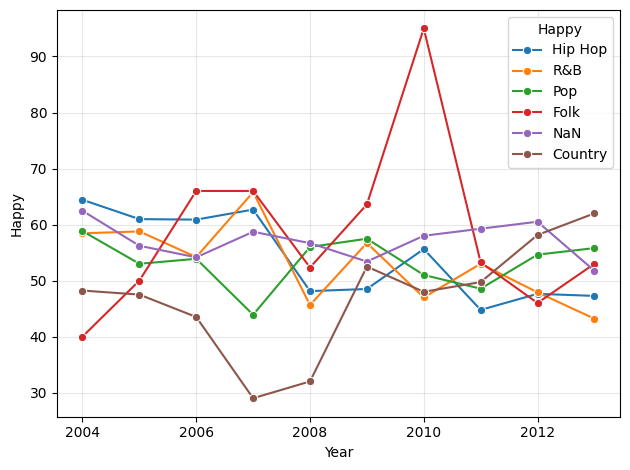

In [109]:
def plot_charts(audio_feature_list):
    for audio_feature in audio_feature_list:
        sns.lineplot(
            data=chart_panel_df,
            x='Year',
            y=audio_feature,
            hue='Genre',
            marker='o'
        )

        plt.legend(title=audio_feature)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_charts(columns_to_read)

In [110]:
def run_did(audio_feature, covariates):
    # Create the interaction term for DiD
    chart_panel_df["did"] = chart_panel_df["Treat_Grp"] * chart_panel_df["post_recession"]

    # Run a fixed-effects (entity & time) DiD regression using OLS with dummy FE
    # Entity FE: C(genre)
    # Time FE: C(year)
    covariate_string = '+'.join(covariates)
    model = smf.ols(
        formula=f"{audio_feature} ~ did + C(Genre) + C(Year) + {covariate_string}",
        data=chart_panel_df
    ).fit(cov_type="HC1")  # HC1 = robust (heteroskedasticity-consistent)

    print(model.summary())

for i in columns_to_read:
    run_did(i, covariates)

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     822.6
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           5.50e-40
Time:                        11:41:35   Log-Likelihood:                -195.20
No. Observations:                  50   AIC:                             420.4
Df Residuals:                      35   BIC:                             449.1
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             115.1959    

synthetic control trial

In [111]:
sc_data = chart_panel_df.sort_values(by=['Genre', "Year"])
#sc_data["Year"] = pd.to_numeric(sc_data["Year"])
sc_data["post_recession"] = pd.to_numeric(sc_data["post_recession"])

features = columns_to_read.extend(["GDP_growth"])

sc_data2 = sc_data[sc_data.post_recession == 0] \
            .drop(['post_recession',"Treat_Grp", "did", "BPM", "Energy", "Happy", "GDP_growth"], axis=1) \
            .reset_index() \
            .set_index("Genre") \
            .drop("index", axis=1)

inverted = sc_data2.pivot_table(index="Genre", columns="Year", values="Dance").T
y = inverted["Pop"].values # pop
X = inverted.drop(columns=["Pop"]).values  # other states

In [112]:
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

weights = get_w(X, y)
print("Sum:", weights.sum())
np.round(weights, 4)

Sum: 1.000000000000004


array([0.7551, 0.    , 0.2449, 0.    , 0.    ])

In [113]:
sc_data3 = sc_data.reset_index()
sc_data3 = sc_data3[sc_data3.Genre != "Pop"].sort_values("Genre").set_index("Genre")
synth_lr = sc_data3.pivot_table(index='Genre', columns="Year", values="Dance").T.values.dot(weights)
synth_lr

array([61.93477307, 59.87764747, 58.58445148, 56.38253476, 54.72296765,
       61.0832985 , 62.16075297, 57.71327393, 59.03171712, 59.37809131])

In [114]:
sc_data4 = sc_data.reset_index()

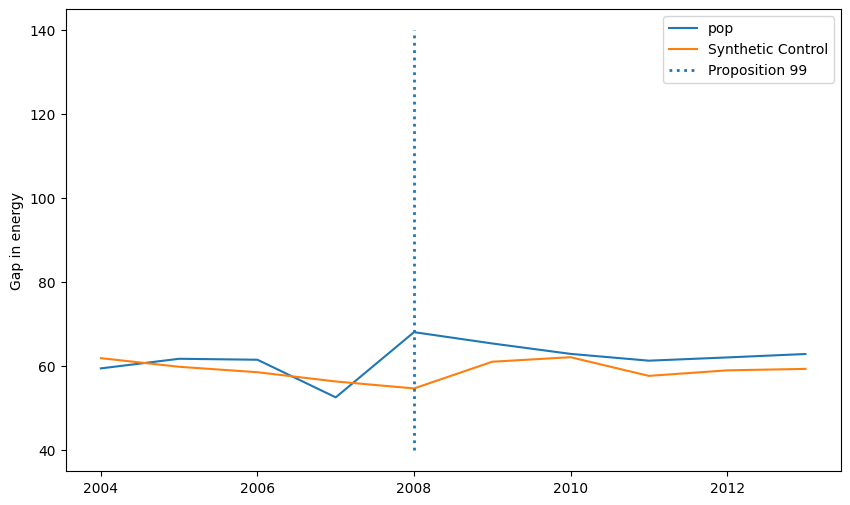

In [115]:
plt.figure(figsize=(10,6))
plt.plot(sc_data4.loc[sc_data4["Genre"] == "Pop"]["Year"], sc_data4.loc[sc_data4["Genre"] == "Pop"]["Dance"], label="pop")
plt.plot(sc_data4.loc[sc_data4["Genre"] == "Pop"]["Year"], synth_lr, label="Synthetic Control")
plt.vlines(x=2008, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in energy")
plt.legend();

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(sc_data4.loc[sc_data4["Genre"] == "Pop"]["Year"], sc_data4.loc[sc_data4["Genre"] == "Pop"]["Dance"] - synth_lr,
         label="Recession Effect", color="red")
plt.vlines(x=2008, ymin=-3, ymax=15, linestyle=":", lw=2, label="Recession")
plt.hlines(y=0, xmin=2004, xmax=2013,lw=2)
plt.title("Pop - Synthetic Across Time")
plt.ylabel("Gap in dance")
plt.legend();

In [ ]:
def synthetic_control(genre, data) -> np.array:
    
    #features = ["Dance"]

    inverted = data.pivot_table(index="Genre", columns="Year", values="Dance").T
    y = inverted["Pop"].values # pop
    X = inverted.drop(columns=["Pop"]).values  # other states
    
    y = inverted[genre].values # treated
    X = inverted.drop(columns=genre).values # donor pool

    weights = get_w(X, y)

    synthetic = data.reset_index()
    synthetic = synthetic[synthetic.Genre != genre].sort_values("Genre").set_index("Genre").pivot_table(index='Genre', columns="Year", values="Dance").T.values.dot(weights)

    return (data.query(f"Genre=={genre}")[["state", "year", "cigsale", "after_treatment"]].assign(synthetic=synthetic))

synthetic_control("Pop", sc_data2).head()